In [1]:
import os, sys
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker

# special tools
import file_tools as ft

In [2]:
# CCI directory:
CCI_directory = 'datasets'

# select CCI in situ product: chla, iopskdtsm, rrs
insitu_product = 'rrs'

# select CCI in situ spectral resolution: 2, 6, fullrange
insitu_resolution = '2'

# subset region
subset_extents = [10, 30, 50, 70]
#subset_extents = [-180, -140, 10, 40]
#subset_extents = [-180, 180, -90, 90]

# subset dates & times:
date_start = '2016-06-01 00:00:00'
date_end = '2019-12-31 23:59:59'

# verbosity
verbose = False
show_plots = True

# plot control
fsz = 20

In [3]:
insitu_headers, insitu_data = ft.read_insitu_file(CCI_directory, insitu_product, insitu_resolution)
lat_col, lon_col, time_col = ft.get_cols(insitu_headers)

lats = np.asarray([float(i) for i in insitu_data[:, lat_col]])
lons = np.asarray([float(i) for i in insitu_data[:, lon_col]])
dates_times = np.asarray([datetime.datetime.strptime(i,"%Y-%m-%dT%H:%M") for i in insitu_data[:, time_col]])

In [4]:
# find rows that matching our subset criteria
ii = np.where((lons >= subset_extents[0]) & (lons <= subset_extents[1])\
            & (lats >= subset_extents[2]) & (lats <= subset_extents[3])\
            & (dates_times >= datetime.datetime.strptime(date_start,"%Y-%m-%d %H:%M:%S"))\
            & (dates_times <= datetime.datetime.strptime(date_end,"%Y-%m-%d %H:%M:%S")))[0]
insitu_data = insitu_data[ii,:]
lats = lats[ii]
lons = lons[ii]
dates_times = dates_times[ii]
print(str(len(ii)) + ' rows in scope')

341 rows in scope


In [5]:
# histogram bin the values onto a res x res grid to help adding numbers to the plot
res = 0.25
lon_grid = np.arange(int(subset_extents[0]),int(subset_extents[1])+1, res)
lat_grid = np.arange(int(subset_extents[2]),int(subset_extents[3])+1, res)
Hist, xedges, yedges = np.histogram2d(lons, lats, bins=(lon_grid, lat_grid))

# a little processing
Hist = Hist.T
Hist[Hist==0] = np.nan
plot_lon = (xedges[1:] + xedges[0:-1]) / 2
plot_lat = (yedges[1:] + yedges[0:-1]) / 2
LON, LAT = np.meshgrid(plot_lon, plot_lat)
HIST = Hist.ravel()
LON = LON.ravel()
LAT = LAT.ravel()

In [6]:
if verbose:
    for row in range(np.shape(insitu_data)[0]):
        print('Lon: ' + str(insitu_data[row, lon_col])\
           + ' Lat: ' + str(insitu_data[row, lat_col])\
           + ' Time: ' + str(dates_times[row]))

In [7]:
# tinkering with dates for plotting
dates_origin = np.asarray([tt.toordinal() for tt in dates_times])
dates_origin = (dates_origin - np.nanmin(dates_origin)) / (np.nanmax(dates_origin) - np.nanmin(dates_origin))

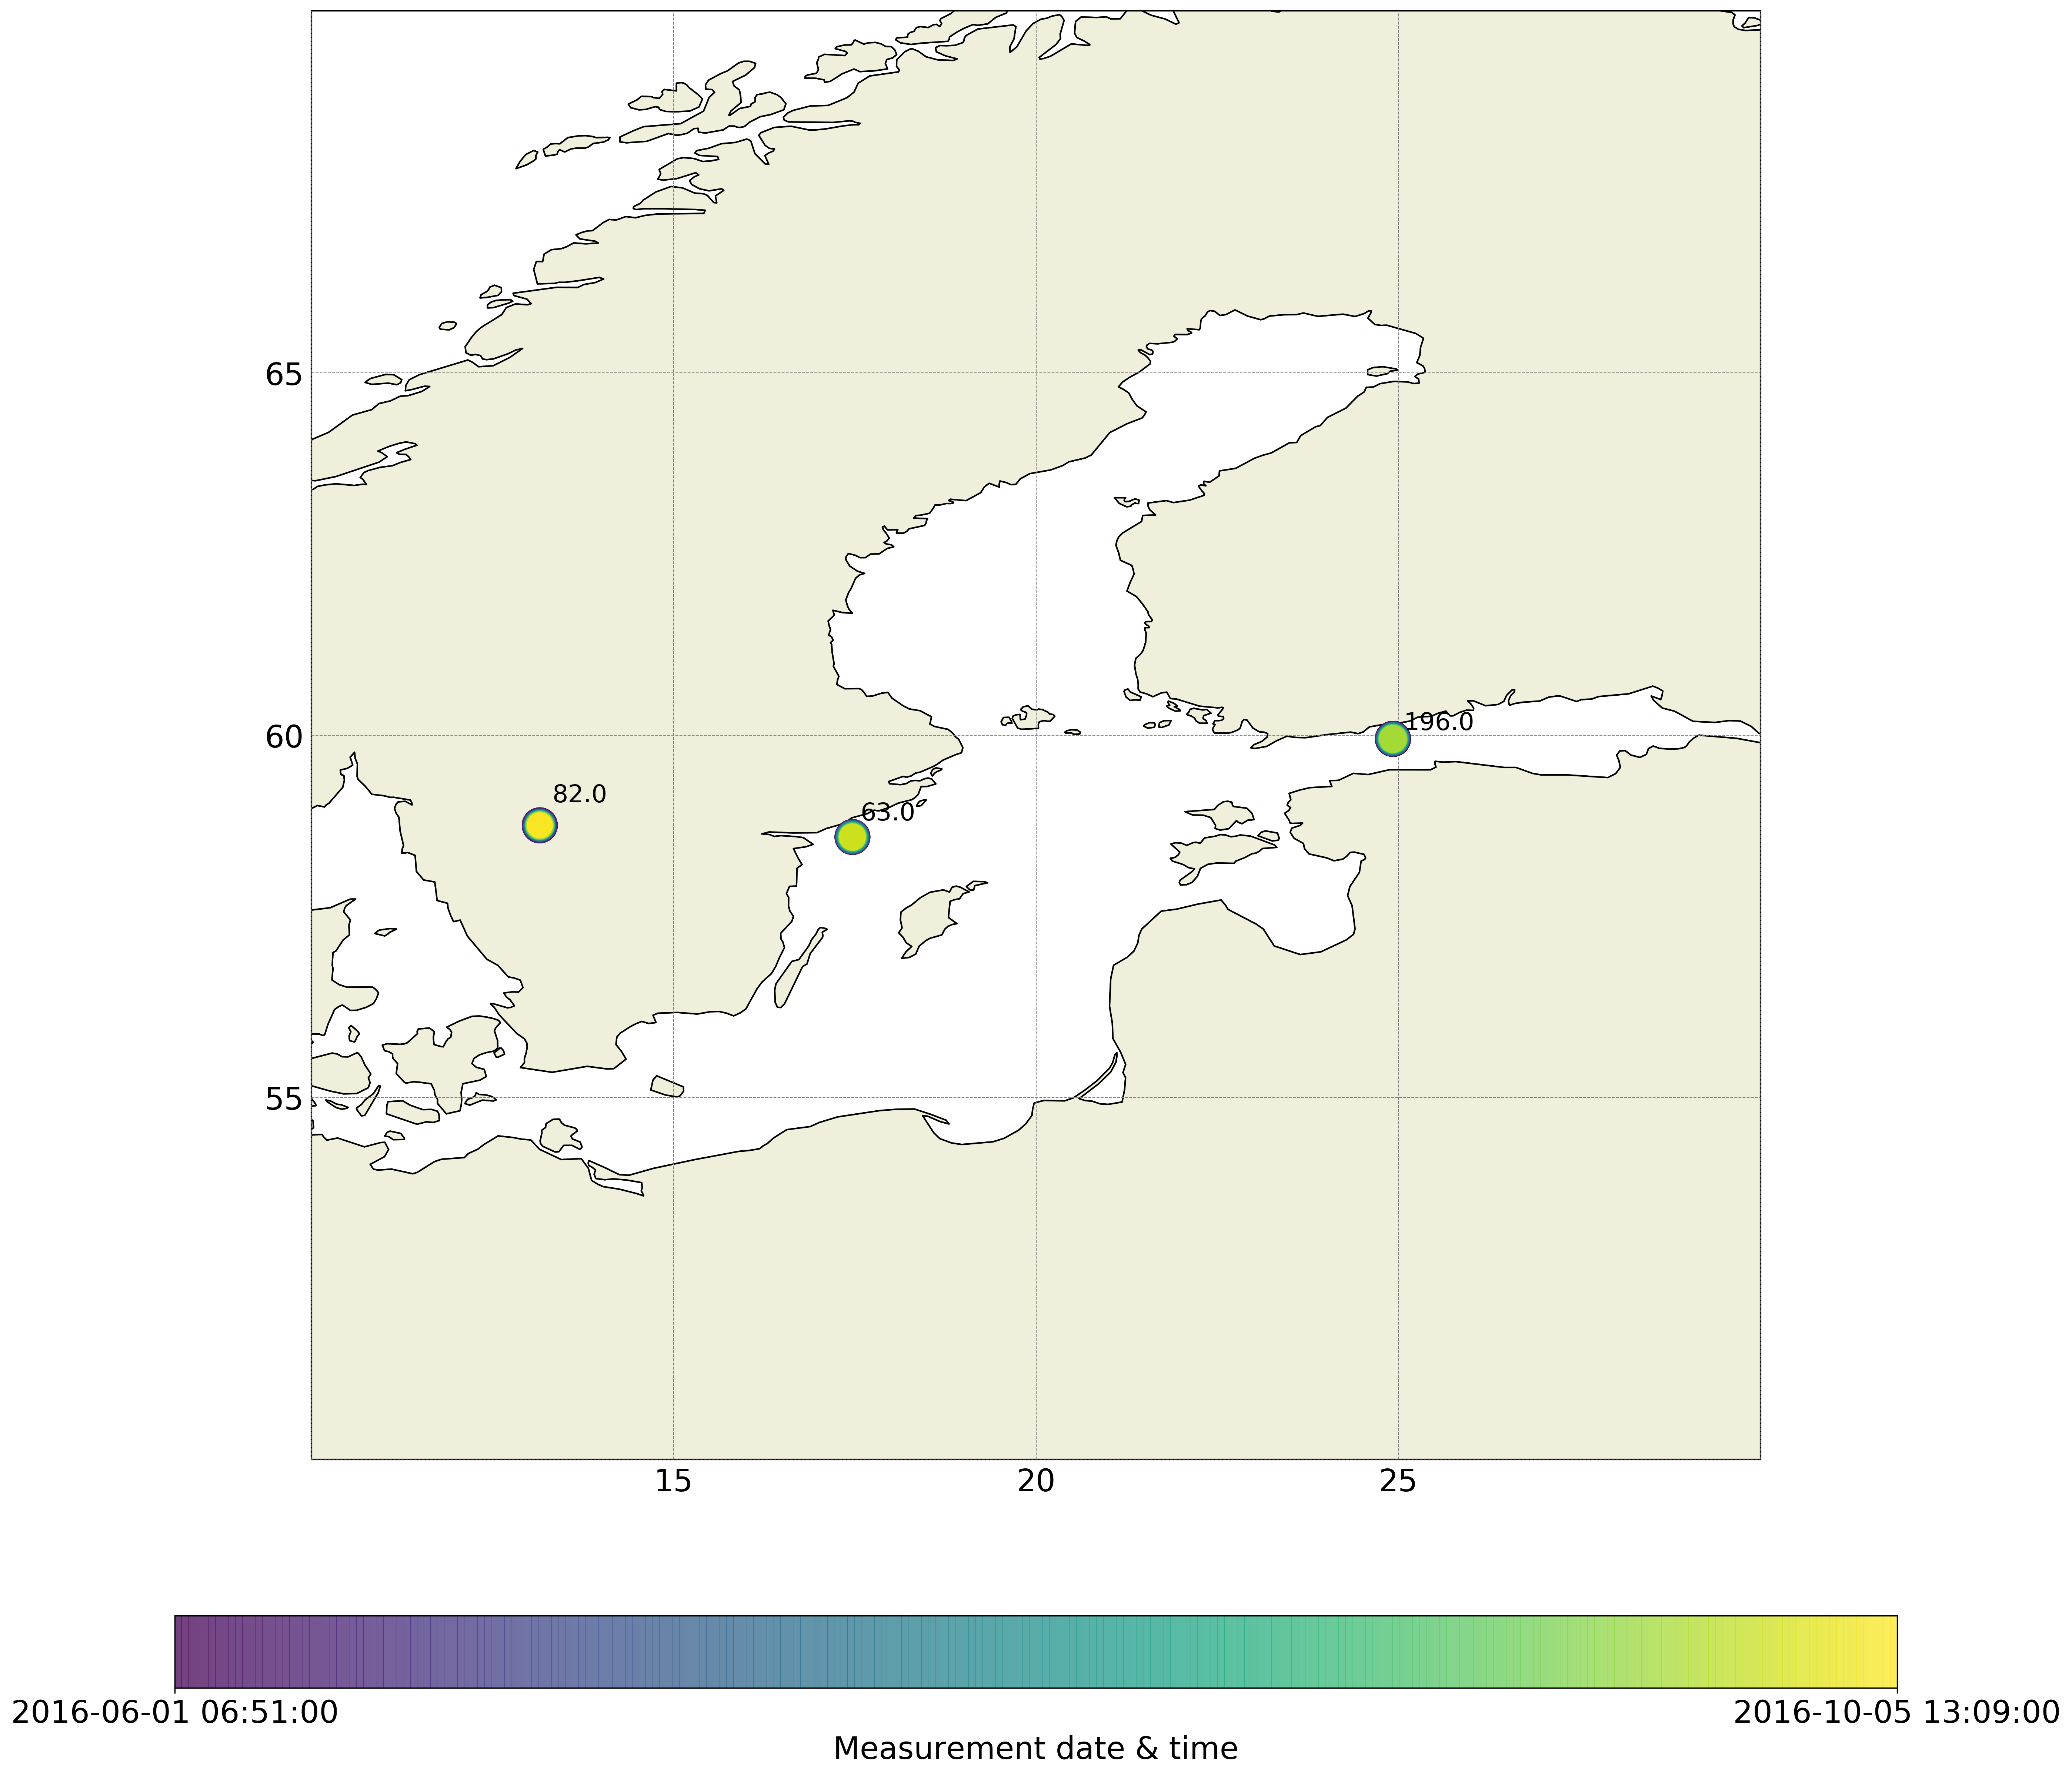

In [9]:
if show_plots:
    # get our land mask from NaturalEarth
    land_resolution = '50m'
    land_poly = cfeature.NaturalEarthFeature('physical', 'land', land_resolution,\
                edgecolor='k',facecolor=cfeature.COLORS['land'])

    # intitialise our figure
    xsize = 20
    ysize = xsize*(subset_extents[3] - subset_extents[2]) / (subset_extents[1] - subset_extents[0])
    fig1 = plt.figure(figsize=(xsize, ysize), dpi=300)
    plt.rc('font', size=fsz)
    matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
    
    # make an axis
    gs = gridspec.GridSpec(3, 1, height_ratios=[20,2,1])
    gs.update(wspace=0.01, hspace=0.01)
    m = plt.subplot(gs[0,0], projection=ccrs.PlateCarree())

    # plot the data
    kk = np.argsort(dates_origin)
    plot1 = m.scatter(lons[kk], lats[kk], s=(dates_origin[kk]*-1+2)*250,
                      c=dates_origin[kk], zorder=100,
                      cmap=plt.cm.viridis, alpha=0.75,
                      transform=ccrs.PlateCarree())
    
    # embellish with gridlines and ticks
    m.coastlines(resolution=land_resolution, color='black', linewidth=1)
    m.add_feature(land_poly)
    m.set_extent(subset_extents, ccrs.PlateCarree())
    g1 = m.gridlines(draw_labels = True, zorder=20, color='0.5', linestyle='--',linewidth=0.5)
    g1.xlocator = mticker.FixedLocator(np.linspace(int(subset_extents[0]),\
                                               int(subset_extents[1]), 5))
    g1.ylocator = mticker.FixedLocator(np.linspace(int(subset_extents[2]),\
                                               int(subset_extents[3]), 5))
    g1.xlabels_top = False
    g1.ylabels_right = False
    g1.xlabel_style = {'size': fsz, 'color': 'black'}
    g1.ylabel_style = {'size': fsz, 'color': 'black'}

    # add annotation numbers
    for hh in range(len(HIST)):
        if np.isnan(HIST[hh]):
            continue      
        else:
            dx = (subset_extents[1] - subset_extents[0])/100
            dy = (subset_extents[3] - subset_extents[2])/100
            plt.annotate(str(HIST[hh]), xy=(LON[hh]+dx, LAT[hh]+dy),\
                         xycoords='data', size=fsz/1.25,\
                         color='k', zorder=100)
    
    # add colorbar
    axes0 = plt.subplot(gs[2,0])
    cbar = plt.colorbar(plot1, cax=axes0, orientation='horizontal',ticks=[0, 1])
    cbar.ax.set_xticklabels([min(dates_times), max(dates_times)])
    cbar.ax.tick_params(labelsize=fsz) 
    cbar.set_label('Measurement date & time',fontsize=fsz)